In [1]:
%matplotlib inline
# import necessary modules
# reading data
import os
import netCDF4 as nc
# operation data
import numpy as np
import pandas as pd
import math
from datetime import datetime, timedelta
#from mpl_toolkits.basemap import Basemap
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist
# visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable, inset_locator
from matplotlib.ticker import AutoMinorLocator
# machine learing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KernelDensity
#import hdbscan
import debacl as dcl
import networkx as _nx
# saving as pdf
#from matplotlib.backends.backend_pdf import PdfPages

In [2]:
#get the file path for loading, data file is under the same dir with the notebook
filename="20121015_00_ecmwf_ensemble_forecast.PRESSURE_LEVELS.EUR_LL10.120.pl.nc"
foldername="ECWMF Datasets"
filepath=os.path.join(os.path.dirname(os.getcwd()),foldername,filename)

# read the raw data and extract the needed data
# exrtact the value of Geopotential under the pressure of 500 hPA in the certain
Pressure_Levels_data = nc.Dataset(filepath,"r")
g = 9.80655
# get all the dimension value
nd_1,nd_2,nd_3,nd_4,nd_5 = Pressure_Levels_data.variables['Geopotential_isobaric'][:].shape
# get the necessary raw data
Geopotential_Isobaric_500 = Pressure_Levels_data.variables['Geopotential_isobaric'][0,:,7,:,:]/g
# reshape the dataset into form of (51,41*101)
Geopotential_Isobaric_500_reshaped = np.reshape(Geopotential_Isobaric_500,(nd_2, nd_4 * nd_5))
# prepare the longitude and latitude value for contour
longitude = Pressure_Levels_data['lon'][:]
latitude = Pressure_Levels_data['lat'][:]
(lon, lat) = np.meshgrid(longitude, latitude)

# use PCA to reduce dimensions under the condition of reaching 80% of all the member infomation
exp_var = 0
n_pc = 0
while exp_var < 0.8:
    n_pc = n_pc + 1
    pca = PCA(n_components = n_pc)
    pca.fit(Geopotential_Isobaric_500_reshaped)
    exp_var = sum(pca.explained_variance_ratio_)

# get the transformed raw data in the dimension-reduced space    
pca_transformed_data = pca.transform(Geopotential_Isobaric_500_reshaped)

#get the time variable
times=Pressure_Levels_data.variables["time"]
#get the time number
arrDateEnd=nc.num2date(times[:],units=times.units)
#get the time in date format
dateEndDate = datetime.date(arrDateEnd[0]).strftime("%d %b %Y")
dateEndMin = datetime.date(arrDateEnd[0]).strftime("%H:%M")
dateStart=datetime.date(arrDateEnd[0])-timedelta(hours=120)
dateStartDate=dateStart.strftime("%d %b %Y")
dateStartMin=dateStart.strftime("%H:%M")

In [3]:
def Get_Subgrid(longitude,latitude,bottomLeft,topRight):
    lonStart=(np.abs(longitude - bottomLeft[0])).argmin()
    lonEnd=(np.abs(longitude - topRight[0])).argmin()
    latStart=(np.abs(latitude - bottomLeft[1])).argmin()
    latEnd=(np.abs(latitude - topRight[1])).argmin()
    
    return lonStart,lonEnd,latStart,latEnd

def Get_Meshgrid(lonStart,lonEnd,latStart,latEnd):
    long=longitude[lonStart:lonEnd+1]
    lati=latitude[latEnd:latStart+1]
    (lon,lat)=np.meshgrid(long,lati)
    
    return lon,lat

def Get_Area_Data(data,lonStart,lonEnd,latStart,latEnd):
    areaData=data[:,latEnd:latStart+1,lonStart:lonEnd+1]
    
    return areaData

def Reshape_New_Data(areaData):
    dim1,dim2,dim3=areaData.shape
    reshapedData=np.reshape(areaData,(dim1,dim2*dim3))
    return reshapedData

def PCA_Run(data):
    exp_var = 0
    n_pc = 0
    while exp_var < 0.8:
        n_pc = n_pc + 1
        pca = PCA(n_components = n_pc)
        pca.fit(data)
        exp_var = sum(pca.explained_variance_ratio_)
        
    return pca


In [4]:
from sklearn import preprocessing
#get the file path for loading, data file is under the same dir with the notebook
filename="20121017_12_ecmwf_forecast.PRESSURE_LEVELS.EUR_LL015.036.pl.nc"
foldername="ECWMF Datasets"
filepath=os.path.join(os.path.dirname(os.getcwd()),foldername,filename)
syn = nc.Dataset(filepath,"r")
#syn.variables
longitude1 = syn['lon'][:]
latitude1 = syn['lat'][:]
(lon1, lat1) = np.meshgrid(longitude1, latitude1)
syndata =syn.variables['Geopotential_isobaric'][:]/9.8
syndataiso1 = syndata[0,:,0,:,:]
syndataiso2 = syndata[0,:,1,:,:]
syndataiso3 = syndata[0,:,2,:,:]

lonStart1,lonEnd1,latStart1,latEnd1 = Get_Subgrid(longitude1,latitude1,[-10,35],[20,65])
secData1 = Get_Area_Data(syndataiso3,lonStart1,lonEnd1,latStart1,latEnd1)
reshapeData1=Reshape_New_Data(secData1)

PCA_1=PCA_Run(reshapeData1)
transformedData1=PCA_1.transform(reshapeData1)


+----+--------------+--------------+------+--------+----------+
| id | start_level  |  end_level   | size | parent | children |
+----+--------------+--------------+------+--------+----------+
| 0  | 0.0000000000 | 0.0026170264 |  51  |  None  |  [1, 2]  |
| 1  | 0.0026170264 | 0.0034327938 |  29  |   0    |  [3, 4]  |
| 2  | 0.0026170264 | 0.0035650762 |  8   |   0    |    []    |
| 3  | 0.0034327938 | 0.0123881013 |  15  |   1    |    []    |
| 4  | 0.0034327938 | 0.0047650409 |  9   |   1    |    []    |
+----+--------------+--------------+------+--------+----------+


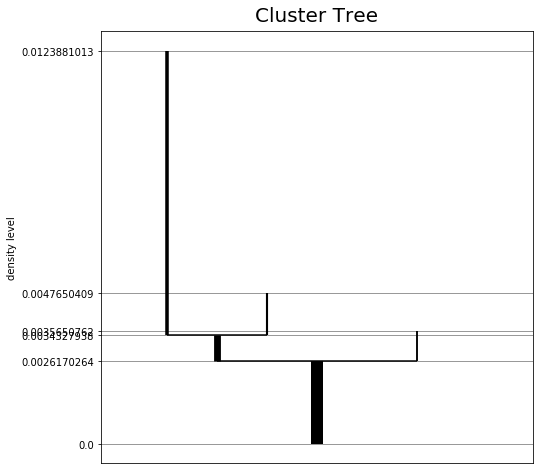

In [57]:
tree = dcl.construct_tree(transformedData1[:,0:1], k=10,prune_threshold=3) 
print tree
fig= tree.plot(form='density',horizontal_spacing="proportional",colormap="Paired")[0]
fig.show()

In [58]:
tree.get_density()

array([0.00736798, 0.00826148, 0.00159885, 0.00273736, 0.00261703,
       0.01090661, 0.00442196, 0.0043282 , 0.00343279, 0.00222459,
       0.00412419, 0.00407881, 0.00097698, 0.00729085, 0.00258691,
       0.0029054 , 0.0035963 , 0.00112931, 0.00340702, 0.0075848 ,
       0.00459949, 0.00752823, 0.0029054 , 0.00280307, 0.0030002 ,
       0.00298118, 0.00327403, 0.00391855, 0.00098043, 0.00282006,
       0.00246521, 0.00476504, 0.0021781 , 0.0123881 , 0.00904984,
       0.00476504, 0.01138529, 0.0034086 , 0.00850425, 0.00274972,
       0.00173562, 0.00140939, 0.00190051, 0.00128052, 0.00460259,
       0.00772581, 0.00601441, 0.00401664, 0.00343497, 0.00356508,
       0.00132068])

In [7]:
sim_graph, radii = dcl.utils.knn_graph(transformedData1[:,0:1], 9)
density = dcl.utils.knn_density(radii,transformedData1[:,0:1].shape[0],transformedData1[:,0:1].shape[1],9)
massgrid = dcl.utils.define_density_mass_grid(density)

In [8]:
density

array([0.00718977, 0.00842781, 0.00177371, 0.00294235, 0.00239877,
       0.01177357, 0.00484568, 0.00517807, 0.0031303 , 0.0026616 ,
       0.00485859, 0.00384493, 0.0009939 , 0.00762463, 0.00268307,
       0.00307101, 0.00339211, 0.0011727 , 0.00384493, 0.00765383,
       0.00503064, 0.00735515, 0.00303424, 0.00414483, 0.00272674,
       0.00296561, 0.00306117, 0.00420461, 0.00099787, 0.00296561,
       0.00225767, 0.00498422, 0.00258816, 0.01273166, 0.00935116,
       0.00482684, 0.01223188, 0.00371515, 0.00842781, 0.00401679,
       0.00196453, 0.00152159, 0.00189453, 0.00135768, 0.00428247,
       0.00743533, 0.00626738, 0.00390829, 0.00311014, 0.00366335,
       0.00140813])